# Import Libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
from tkinter.filedialog import askdirectory
import tkinter as tk
from ipywidgets import interact, widgets, fixed, interactive, HBox, Layout
import pickle
from sklearn.metrics import auc
import seaborn as sns
import pandas as pd
from scipy.interpolate import RectBivariateSpline


# Custom Functions
from FunctionsAll import *

# Egg

### Load Data and Visualise

In [62]:
mainPth = r'C:\IBECPostDocDrive\2025_11_10_CheShImP_MRMJournal\Data' # Directory where all the result folders are

exps = [r'\Egg\20240502_151231_ESL_EggsImages_ESL_EggsImages_1_1\17_CSI',
        ] # List of experiments (and CSI folder) to analyse

In [63]:
ppms = {}
CSIs = {}
for i in range(len(exps)):
    ppms[str(i)] = sp.io.loadmat(mainPth+exps[i]+r'\tmp_img\ppms.mat')['ppms'][0]   
    if i == 0:
        CSIs[str(i)] = sp.io.loadmat(mainPth+exps[i]+r'\tmp_img\AllData.mat')['FDat']
    else: 
        CSIs[str(i)] = sp.io.loadmat(mainPth+exps[i]+r'\tmp_img\AllData.mat')['FDat'][::,::,::,0,0,0,0]

### Inspec CSI Processed Data

In [94]:
inspecCSI(ppms, CSIs)    

interactive(children=(Dropdown(description='Exp.:', options=(1,), value=1), IntSlider(value=0, description='Co…

In [64]:
genCSI(CSIs, '1_RatiosMap_Egg')

interactive(children=(Dropdown(description='Exp.:', options=(1,), value=1), FloatRangeSlider(value=(5.0, 5.0),…

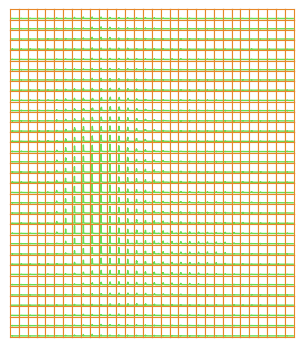

In [64]:
plotCSIDat2(CSIs, savNM="1_RatiosMap_Egg", exp = 1, scF = [3.545,4.095], lw1 = 1, mnn = -0.1, mxx = 0.82, xzm = [350,900], sav = True)

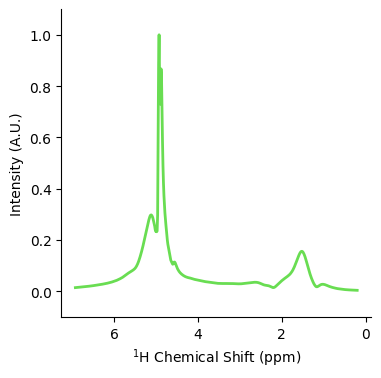

In [65]:
exp = 1
j,i = 14,20

savNM = "1_RatiosMap_Egg"


sizDt = np.shape(CSIs[str(exp-1)])
mxdt = np.max(CSIs[str(exp-1)][::,j,i])
mndt = np.min(CSIs[str(exp-1)][::,j,i])

fig2, ax2 = plt.subplots(figsize=(4,4))
            
ax2.spines[['right', 'top']].set_visible(False)

ax2.set_ylim(-0.1,1.1)
ax2.plot(ppms['0'][320:900], (CSIs[str(exp-1)][320:900,j,i] - mndt) / (mxdt - mndt),  color="#69dd52ff", linewidth = 2)
ax2.set_ylabel("Intensity (A.U.)")
ax2.set_xlabel("$^{1}$H Chemical Shift (ppm)")
ax2.set_xlim(ax2.get_xlim()[::-1])

plt.savefig('Processed/'+savNM+'ExampleSpectra_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM+'ExampleSpectra_Exp'+str(exp)+'.png')

plt.show()

These peaks can be quantified to determine the fatty acid profile of a sample, with specific values like \(0.9\) ppm for methyl groups and \(2.0-2.3\) ppm for allylic methylene groups serving as important markers. 

Key ¹H NMR signals for fats Olefinic protons: Protons on double bonds (\(–CH=CH–\)) appear in the \(5.2–5.5\) ppm region.Saturated methyl group (\(CH_{3}\)): A signal around \(0.9\) ppm is characteristic of saturated fatty acid methyl groups.Saturated methylene group (\(CH_{2}\)): The main saturated methylene groups appear around \(1.3\) ppm.Allylic methylene group (\(–CH_{2}–CH=CH–\)): Protons adjacent to a double bond resonate at approximately \(2.0–2.3\) ppm.Glycerol backbone: Protons on the glycerol moiety are found around \(4.1–4.3\) ppm, corresponding to the esterified positions.Terminal vinyl group (\(CH_{2}=CH–\)): Protons in a terminal vinyl group can appear around \(4.9\) and \(5.8\) ppm.Conjugated double bonds: Protons in conjugated systems (\(–CH=CH–CH=CH–\)) are typically found between \(5.5\) and \(6.35\) ppm. 

### Select Integration Regions for Water and Fat

In [7]:
dispInts(ppms, CSIs, intNM = 'IntegrParsEgg')

In [66]:
with open('Processed/'+'IntegrParsEgg'+'.p', 'rb') as fp:
    intPars = pickle.load(fp)
intPars

{'0': [(-5.9053130065477495, -4.2708355065477495),
  (-2.179800006547751, -1.1205856065477509)]}

### Generate and visualise the ratios map for each experiment

In [67]:
# Generate normalised matrix by maximum of each row to account for lower signals due to magnetic inhomogeneities
CSIs_FC_NRMRW = {}

for ex in range(len(CSIs)):
    shp = np.shape(CSIs[str(ex)])

    CSIs_FC_NRMRW[str(ex)] = np.zeros(shp)
    
    for ii in range(shp[2]):
        mxrw = np.max([np.max(CSIs[str(ex)][::,jj,ii]) for jj in range(shp[1])])
        CSIs_FC_NRMRW[str(ex)][::,::,ii] = CSIs[str(ex)][::,::,ii] #/ mxrw

In [ ]:
# GnBu
# YlOrBr

In [ ]:
pltRatsMaps(ppms, CSIs_FC_NRMRW, intNM = 'IntegrParsEgg', savNM = '1_RatiosMap_Egg', logg=True)

interactive(children=(FloatSlider(value=0.5, description='Zoom', layout=Layout(width='1400px'), max=2.0, min=0…

In [68]:
pyrINT = {}
lacINT = {}

for ex in range(len(CSIs_FC_NRMRW)):
    pyrIntR = np.logical_and(ppms[str(ex)] >= np.abs(intPars[str(ex)][0])[1],  ppms[str(ex)] <= np.abs(intPars[str(ex)][0])[0])
    lacIntR = np.logical_and(ppms[str(ex)] >= np.abs(intPars[str(ex)][1])[1],  ppms[str(ex)] <= np.abs(intPars[str(ex)][1])[0])
    
    sizDt = np.shape(CSIs_FC_NRMRW[str(ex)])
    pyrMat = np.zeros([sizDt[1], sizDt[2]])
    lacMat = np.zeros([sizDt[1], sizDt[2]])

    for i in range(sizDt[2]):
        for j in range(sizDt[1]):
            pyrMat[j,i] = auc(ppms[str(ex)][pyrIntR], CSIs_FC_NRMRW[str(ex)][pyrIntR, j,i])
            lacMat[j,i] = auc(ppms[str(ex)][lacIntR], CSIs_FC_NRMRW[str(ex)][lacIntR, j,i])
            
    pyrINT[str(ex)] = pyrMat
    lacINT[str(ex)] = lacMat

In [69]:
dms = []
with open(mainPth+'/'+exps[0]+'/visu_pars', 'r+') as f:
    for line in f:
        if 'VisuCoreExtent' in line.strip():
            dms = np.fromstring(next(f,''), dtype=float, sep=' ' )
            break

array([33.4468, 40.9539])

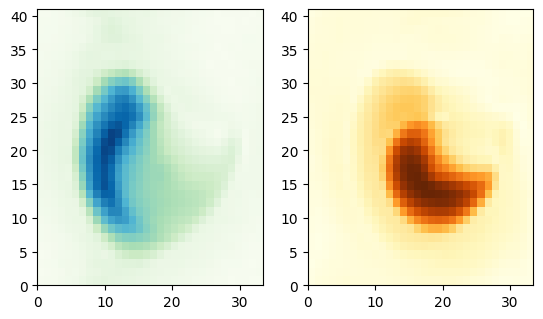

In [70]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(np.transpose(pyrINT[str(0)]), cmap = 'GnBu',  extent = [0, dms[-2::][0], 0, dms[-2::][1]])
ax2.imshow(np.transpose(lacINT[str(0)]), cmap = 'YlOrBr',  extent = [0, dms[-2::][0], 0, dms[-2::][1]])

plt.savefig('Processed/'+savNM+'WaterFatVoxels_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM+'WaterFatVoxels_Exp'+str(exp)+'.png')

plt.show()

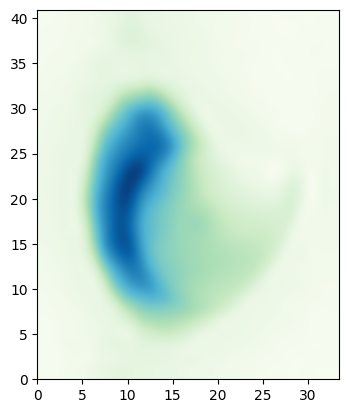

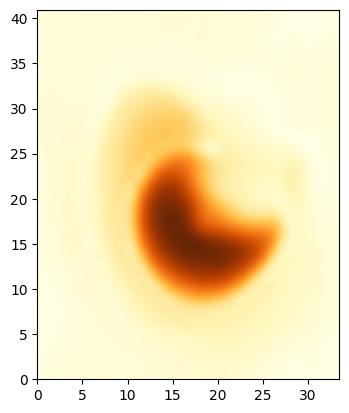

In [71]:
f = RectBivariateSpline(range(np.shape(pyrINT[str(0)])[0]), range(np.shape(pyrINT[str(0)])[1]), pyrINT[str(0)])
x2 = np.linspace(0, np.shape(pyrINT[str(0)])[0], 2000)
y2 = np.linspace(0, np.shape(pyrINT[str(0)])[1], 2000)
Z2 = f(x2, y2).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'GnBu',  extent = [0, dms[-2::][0], 0, dms[-2::][1]])

plt.savefig('Processed/'+savNM+'WaterSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM+'WaterSmooth_Exp'+str(exp)+'.png')

plt.show()



f = RectBivariateSpline(range(np.shape(lacINT[str(0)])[0]), range(np.shape(lacINT[str(0)])[1]), lacINT[str(0)])
x2 = np.linspace(0, np.shape(lacINT[str(0)])[0], 2000)
y2 = np.linspace(0, np.shape(lacINT[str(0)])[1], 2000)
Z2 = f(x2, y2).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'YlOrBr',  extent = [0, dms[-2::][0], 0, dms[-2::][1]])

plt.savefig('Processed/'+savNM+'FatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM+'FatSmooth_Exp'+str(exp)+'.png')

plt.show()

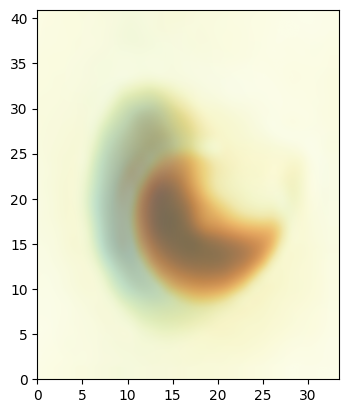

In [72]:
f = RectBivariateSpline(range(np.shape(pyrINT[str(0)])[0]), range(np.shape(pyrINT[str(0)])[1]), pyrINT[str(0)])
x2 = np.linspace(0, np.shape(pyrINT[str(0)])[0], 2000)
y2 = np.linspace(0, np.shape(pyrINT[str(0)])[1], 2000)
Z2 = f(x2, y2).T

fb = RectBivariateSpline(range(np.shape(lacINT[str(0)])[0]), range(np.shape(lacINT[str(0)])[1]), lacINT[str(0)])
x2b = np.linspace(0, np.shape(lacINT[str(0)])[0], 2000)
y2b = np.linspace(0, np.shape(lacINT[str(0)])[1], 2000)
Z2b = fb(x2b, y2b).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'GnBu',  extent = [0, dms[-2::][0], 0, dms[-2::][1]], alpha=0.9)
ax1.imshow(Z2b, cmap = 'YlOrBr',  extent = [0, dms[-2::][0], 0, dms[-2::][1]], alpha=0.6)

plt.savefig('Processed/'+savNM+'WaterFatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM+'WaterFatSmooth_Exp'+str(exp)+'.png')

plt.show()


# Mice

### Load Data and Visualise

In [28]:
mainPth = r'C:\IBECPostDocDrive\2025_11_10_CheShImP_MRMJournal\Data' # Directory where all the result folders are

exps2 = [r'\Mouse\20251119_161552_DGC_MiceImages_GDC_Control4_Try1_1_1\6_CSI',
        ] # List of experiments (and CSI folder) to analyse

In [29]:
ppms2 = {}
CSIs2 = {}
for i in range(len(exps2)):
    ppms2[str(i)] = sp.io.loadmat(mainPth+exps2[i]+r'\tmp_img\ppms.mat')['ppms'][0]   
    if i == 0:
        CSIs2[str(i)] = sp.io.loadmat(mainPth+exps2[i]+r'\tmp_img\AllData.mat')['FDat']
    else: 
        CSIs2[str(i)] = sp.io.loadmat(mainPth+exps2[i]+r'\tmp_img\AllData.mat')['FDat'][::,::,::,0,0,0,0]

### Inspec CSI Processed Data

In [30]:
inspecCSI(ppms, CSIs2)    

interactive(children=(Dropdown(description='Exp.:', options=(1,), value=1), IntSlider(value=0, description='Co…

In [ ]:
genCSI(CSIs2, '2_RatiosMap_Mice')

interactive(children=(Dropdown(description='Exp.:', options=(1,), value=1), FloatRangeSlider(value=(5.0, 5.0),…

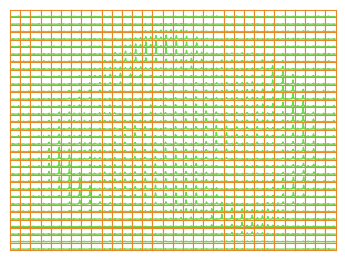

In [33]:
plotCSIDat2(CSIs2, savNM="2_RatiosMap_Mice", exp = 1, scF = [4.069,3.000], lw1 = 1, mnn = -0.1, mxx = 0.82, xzm = [350,900], sav = True)

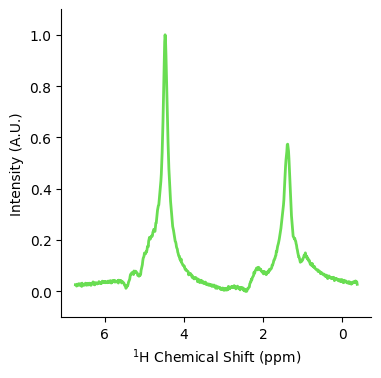

In [37]:
exp = 1
j,i = 14,3

savNM2 = "2_RatiosMap_Mice"


sizDt = np.shape(CSIs2[str(exp-1)])
mxdt = np.max(CSIs2[str(exp-1)][::,j,i])
mndt = np.min(CSIs2[str(exp-1)][::,j,i])

fig2, ax2 = plt.subplots(figsize=(4,4))
            
ax2.spines[['right', 'top']].set_visible(False)

ax2.set_ylim(-0.1,1.1)
ax2.plot(ppms2['0'][320:990], (CSIs2[str(exp-1)][320:990,j,i] - mndt) / (mxdt - mndt),  color="#69dd52ff", linewidth = 2)
ax2.set_ylabel("Intensity (A.U.)")
ax2.set_xlabel("$^{1}$H Chemical Shift (ppm)")
ax2.set_xlim(ax2.get_xlim()[::-1])

plt.savefig('Processed/'+savNM2+'ExampleSpectra_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM2+'ExampleSpectra_Exp'+str(exp)+'.png')

plt.show()

These peaks can be quantified to determine the fatty acid profile of a sample, with specific values like \(0.9\) ppm for methyl groups and \(2.0-2.3\) ppm for allylic methylene groups serving as important markers. 

Key ¹H NMR signals for fats Olefinic protons: Protons on double bonds (\(–CH=CH–\)) appear in the \(5.2–5.5\) ppm region.Saturated methyl group (\(CH_{3}\)): A signal around \(0.9\) ppm is characteristic of saturated fatty acid methyl groups.Saturated methylene group (\(CH_{2}\)): The main saturated methylene groups appear around \(1.3\) ppm.Allylic methylene group (\(–CH_{2}–CH=CH–\)): Protons adjacent to a double bond resonate at approximately \(2.0–2.3\) ppm.Glycerol backbone: Protons on the glycerol moiety are found around \(4.1–4.3\) ppm, corresponding to the esterified positions.Terminal vinyl group (\(CH_{2}=CH–\)): Protons in a terminal vinyl group can appear around \(4.9\) and \(5.8\) ppm.Conjugated double bonds: Protons in conjugated systems (\(–CH=CH–CH=CH–\)) are typically found between \(5.5\) and \(6.35\) ppm. 

### Select Integration Regions for Water and Fat

In [38]:
dispInts(ppms2, CSIs2, intNM = 'IntegrParsMice')

interactive(children=(Dropdown(description='Exp.:', options=(1,), value=1), IntSlider(value=0, description='Co…

In [41]:
with open('Processed/'+'IntegrParsMice'+'.p', 'rb') as fp:
    intPars2 = pickle.load(fp)
intPars2

{'0': [(-5.478431347668801, -3.5951297476688016),
  (-2.389816747668802, -0.5232555476688017)]}

### Generate and visualise the ratios map for each experiment

In [42]:
# Generate normalised matrix by maximum of each row to account for lower signals due to magnetic inhomogeneities
CSIs_FC_NRMRW2 = {}

for ex in range(len(CSIs2)):
    shp = np.shape(CSIs2[str(ex)])

    CSIs_FC_NRMRW2[str(ex)] = np.zeros(shp)
    
    for ii in range(shp[2]):
        mxrw2 = np.max([np.max(CSIs2[str(ex)][::,jj,ii]) for jj in range(shp[1])])
        CSIs_FC_NRMRW2[str(ex)][::,::,ii] = CSIs2[str(ex)][::,::,ii] #/ mxrw2

In [ ]:
# GnBu
# YlOrBr

In [44]:
pltRatsMaps(ppms2, CSIs_FC_NRMRW2, intNM = 'IntegrParsMice', savNM = '2_RatiosMap_Mice', logg=True)

interactive(children=(FloatSlider(value=0.5, description='Zoom', layout=Layout(width='1400px'), max=2.0, min=0…

In [57]:
pyrINT2 = {}
lacINT2 = {}

for ex in range(len(CSIs_FC_NRMRW2)):
    pyrIntR = np.logical_and(ppms2[str(ex)] >= np.abs(intPars2[str(ex)][0])[1],  ppms2[str(ex)] <= np.abs(intPars2[str(ex)][0])[0])
    lacIntR = np.logical_and(ppms2[str(ex)] >= np.abs(intPars2[str(ex)][1])[1],  ppms2[str(ex)] <= np.abs(intPars2[str(ex)][1])[0])
    
    sizDt = np.shape(CSIs_FC_NRMRW2[str(ex)])
    pyrMat = np.zeros([sizDt[1], sizDt[2]])
    lacMat = np.zeros([sizDt[1], sizDt[2]])

    for i in range(sizDt[2]):
        for j in range(sizDt[1]):
            pyrMat[j,i] = auc(ppms2[str(ex)][pyrIntR], CSIs_FC_NRMRW2[str(ex)][pyrIntR, j,i])
            lacMat[j,i] = auc(ppms2[str(ex)][lacIntR], CSIs_FC_NRMRW2[str(ex)][lacIntR, j,i])
            
    pyrINT2[str(ex)] = pyrMat
    lacINT2[str(ex)] = lacMat

In [58]:
dms2 = []
with open(mainPth+'/'+exps[0]+'/visu_pars', 'r+') as f:
    for line in f:
        if 'VisuCoreExtent' in line.strip():
            dms2 = np.fromstring(next(f,''), dtype=float, sep=' ' )
            break

array([33.4468, 40.9539])

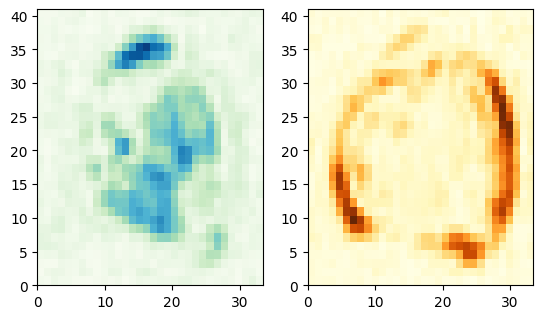

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(np.transpose(pyrINT2[str(0)]), cmap = 'GnBu',  extent = [0, dms2[-2::][0], 0, dms2[-2::][1]])
ax2.imshow(np.transpose(lacINT2[str(0)]), cmap = 'YlOrBr',  extent = [0, dms2[-2::][0], 0, dms2[-2::][1]])

plt.savefig('Processed/'+savNM2+'WaterFatVoxels_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM2+'WaterFatVoxels_Exp'+str(exp)+'.png')

plt.show()

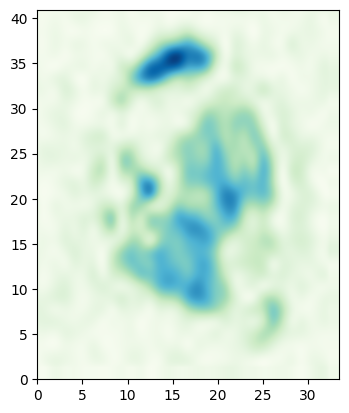

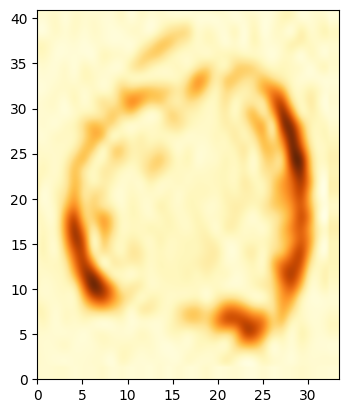

In [60]:
f = RectBivariateSpline(range(np.shape(pyrINT2[str(0)])[0]), range(np.shape(pyrINT2[str(0)])[1]), pyrINT2[str(0)])
x2 = np.linspace(0, np.shape(pyrINT2[str(0)])[0], 2000)
y2 = np.linspace(0, np.shape(pyrINT2[str(0)])[1], 2000)
Z2 = f(x2, y2).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'GnBu',  extent = [0, dms2[-2::][0], 0, dms2[-2::][1]])

plt.savefig('Processed/'+savNM+'WaterSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM+'WaterSmooth_Exp'+str(exp)+'.png')

plt.show()



f = RectBivariateSpline(range(np.shape(lacINT2[str(0)])[0]), range(np.shape(lacINT2[str(0)])[1]), lacINT2[str(0)])
x2 = np.linspace(0, np.shape(lacINT2[str(0)])[0], 2000)
y2 = np.linspace(0, np.shape(lacINT2[str(0)])[1], 2000)
Z2 = f(x2, y2).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'YlOrBr',  extent = [0, dms2[-2::][0], 0, dms2[-2::][1]])

plt.savefig('Processed/'+savNM2+'FatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM2+'FatSmooth_Exp'+str(exp)+'.png')

plt.show()

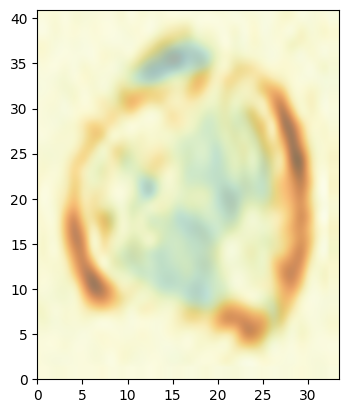

In [61]:
f = RectBivariateSpline(range(np.shape(pyrINT2[str(0)])[0]), range(np.shape(pyrINT2[str(0)])[1]), pyrINT2[str(0)])
x2 = np.linspace(0, np.shape(pyrINT2[str(0)])[0], 2000)
y2 = np.linspace(0, np.shape(pyrINT2[str(0)])[1], 2000)
Z2 = f(x2, y2).T

fb = RectBivariateSpline(range(np.shape(lacINT2[str(0)])[0]), range(np.shape(lacINT2[str(0)])[1]), lacINT2[str(0)])
x2b = np.linspace(0, np.shape(lacINT2[str(0)])[0], 2000)
y2b = np.linspace(0, np.shape(lacINT2[str(0)])[1], 2000)
Z2b = fb(x2b, y2b).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'GnBu',  extent = [0, dms2[-2::][0], 0, dms2[-2::][1]], alpha=0.9)
ax1.imshow(Z2b, cmap = 'YlOrBr',  extent = [0, dms2[-2::][0], 0, dms2[-2::][1]], alpha=0.6)

plt.savefig('Processed/'+savNM2+'WaterFatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM2+'WaterFatSmooth_Exp'+str(exp)+'.png')

plt.show()


# Chip CSI

### Load Data and Visualise

In [2]:
mainPth = r'C:\IBECPostDocDrive\2025_11_10_CheShImP_MRMJournal\Data' # Directory where all the result folders are

exps3 = [r'\Chip\20230921_225221_4wellchip_Fumarate_injection_volumetric_fumarase_1_13\4_CSI',
         r'\Chip\20230803_102235_DGC_EPI_InitialTests_DGC_EPI_InitialTests_1_1\46_CSI_THIS', 
        ] # List of experiments (and CSI folder) to analyse

In [3]:
ppms3 = {}
CSIs3 = {}
for i in range(len(exps3)):
    ppms3[str(i)] = sp.io.loadmat(mainPth+exps3[i]+r'\tmp_img\ppms.mat')['ppms'][0]   
    CSIs3[str(i)] = sp.io.loadmat(mainPth+exps3[i]+r'\tmp_img\AllData.mat')['FDat'][::,::,::,0,0,0,0]

### Inspec CSI Processed Data

In [ ]:
inspecCSI(ppms3, CSIs3)    

interactive(children=(Dropdown(description='Exp.:', options=(1, 2), value=1), IntSlider(value=0, description='…

In [ ]:
genCSI(CSIs3, '3_RatiosMap_Chip')

interactive(children=(Dropdown(description='Exp.:', options=(1,), value=1), FloatRangeSlider(value=(5.0, 5.0),…

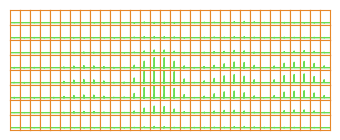

In [4]:
CSIs3a = {}
CSIs3a['0'] = np.transpose(CSIs3['0'], axes=(0, 2, 1))

plotCSIDat2(CSIs3a, savNM="3_RatiosMap_ChipFumarate", exp = 1, scF = [4.0,1.5], lw1 = 1, mnn = -0.1, mxx = 0.82, xzm = [0,512], sav = True)

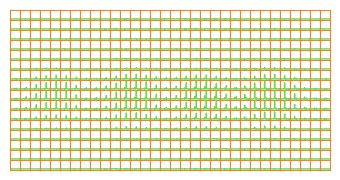

In [5]:
CSIs3b = {}
CSIs3b['0'] = np.transpose(CSIs3['1'], axes=(0, 2, 1))
plotCSIDat2(CSIs3b, savNM="3_RatiosMap_ChipLDH", exp = 1, scF = [4.0,2.0], lw1 = 1, mnn = -0.1, mxx = 0.82, xzm = [0,512], sav = True)

In [242]:
np.shape(CSIs3['1'])

(512, 16, 32)

In [250]:
CSIs3b

{'0': (512, 32, 16)}

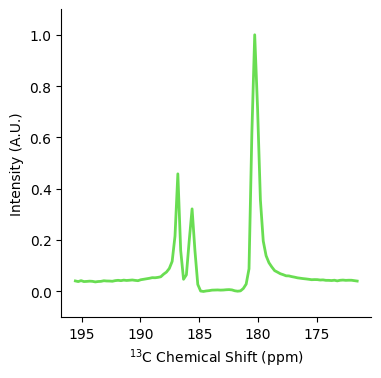

In [48]:
exp = 1
j,i = 4, 21

savNM3a = "3_RatiosMap_ChipFumarate"


sizDt = np.shape(CSIs3[str(exp-1)])
mxdt = np.max(CSIs3[str(exp-1)][::,j,i])
mndt = np.min(CSIs3[str(exp-1)][::,j,i])

fig2, ax2 = plt.subplots(figsize=(4,4))
            
ax2.spines[['right', 'top']].set_visible(False)

ax2.set_ylim(-0.1,1.1)
ax2.plot(ppms3[str(exp-1)][150:250], (CSIs3[str(exp-1)][150:250,j,i] - mndt) / (mxdt - mndt),  color="#69dd52ff", linewidth = 2)
ax2.set_ylabel("Intensity (A.U.)")
ax2.set_xlabel("$^{13}$C Chemical Shift (ppm)")
ax2.set_xlim(ax2.get_xlim()[::-1])

plt.savefig('Processed/'+savNM3a+'ExampleSpectra_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM3a+'ExampleSpectra_Exp'+str(exp)+'.png')

plt.show()

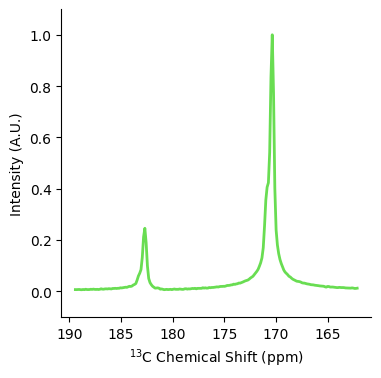

In [47]:
exp = 2
j,i = 8, 18

savNM3b = "3_RatiosMap_ChipLDH"

ppmsfx = np.linspace(261.8202885852775-60, 138.1797114147225, 512)
ppms3[str(exp-1)] = ppmsfx+10

sizDt = np.shape(CSIs3[str(exp-1)])
mxdt = np.max(CSIs3[str(exp-1)][::,j,i])
mndt = np.min(CSIs3[str(exp-1)][::,j,i])

fig2, ax2 = plt.subplots(figsize=(4,4))
            
ax2.spines[['right', 'top']].set_visible(False)

ax2.set_ylim(-0.1,1.1)
ax2.plot(ppms3[str(exp-1)][180:400], (CSIs3[str(exp-1)][180:400,j,i] - mndt) / (mxdt - mndt),  color="#69dd52ff", linewidth = 2)
ax2.set_ylabel("Intensity (A.U.)")
ax2.set_xlabel("$^{13}$C Chemical Shift (ppm)")
ax2.set_xlim(ax2.get_xlim()[::-1])

plt.savefig('Processed/'+savNM3b+'ExampleSpectra_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM3b+'ExampleSpectra_Exp'+str(exp)+'.png')

plt.show()

### Select Integration Regions for Water and Fat

In [ ]:
dispInts(ppms3, CSIs3, intNM = 'IntegrParsChip')

interactive(children=(Dropdown(description='Exp.:', options=(1, 2), value=1), IntSlider(value=0, description='…

In [49]:
with open('Processed/'+'IntegrParsChip'+'.p', 'rb') as fp:
    intPars3 = pickle.load(fp)
intPars3

{'0': [(-182.3777033852775, -174.9456230852775),
  (-189.9999999852775, -183.6630277852775)],
 '1': [(-175.5299175852775, -164.5788361852775),
  (-187.52718848527752, -177.1956744852775)]}

### Generate and visualise the ratios map for each experiment

In [50]:
# Generate normalised matrix by maximum of each row to account for lower signals due to magnetic inhomogeneities
CSIs_FC_NRMRW3 = {}

for ex in range(len(CSIs3)):
    shp = np.shape(CSIs3[str(ex)])

    CSIs_FC_NRMRW3[str(ex)] = np.zeros(shp)
    
    for ii in range(shp[2]):
        mxrw3 = np.max([np.max(CSIs3[str(ex)][::,jj,ii]) for jj in range(shp[1])])
        CSIs_FC_NRMRW3[str(ex)][::,::,ii] = CSIs3[str(ex)][::,::,ii] #/ mxrw3

In [ ]:
# Fumarate - Reds, Blues
# LDH - OrRd, Greens

In [51]:
pltRatsMaps(ppms3, CSIs_FC_NRMRW3, intNM = 'IntegrParsChip', savNM = '3_RatiosMap_Chip', logg=True)

interactive(children=(FloatSlider(value=0.5, description='Zoom', layout=Layout(width='1400px'), max=2.0, min=0…

In [52]:
pyrINT3 = {}
lacINT3 = {}

for ex in range(len(CSIs_FC_NRMRW3)):
    pyrIntR = np.logical_and(ppms3[str(ex)] >= np.abs(intPars3[str(ex)][0])[1],  ppms3[str(ex)] <= np.abs(intPars3[str(ex)][0])[0])
    lacIntR = np.logical_and(ppms3[str(ex)] >= np.abs(intPars3[str(ex)][1])[1],  ppms3[str(ex)] <= np.abs(intPars3[str(ex)][1])[0])
    
    sizDt = np.shape(CSIs_FC_NRMRW3[str(ex)])
    pyrMat = np.zeros([sizDt[1], sizDt[2]])
    lacMat = np.zeros([sizDt[1], sizDt[2]])

    for i in range(sizDt[2]):
        for j in range(sizDt[1]):
            pyrMat[j,i] = auc(ppms3[str(ex)][pyrIntR], CSIs_FC_NRMRW3[str(ex)][pyrIntR, j,i])
            lacMat[j,i] = auc(ppms3[str(ex)][lacIntR], CSIs_FC_NRMRW3[str(ex)][lacIntR, j,i])
            
    pyrINT3[str(ex)] = pyrMat
    lacINT3[str(ex)] = lacMat

In [53]:
dms3 = []
with open(mainPth+'/'+exps3[0]+'/visu_pars', 'r+') as f:
    for line in f:
        if 'VisuCoreExtent' in line.strip():
            dms3 = np.fromstring(next(f,''), dtype=float, sep=' ' )
            break

array([33.4468, 40.9539])

(8, 32)

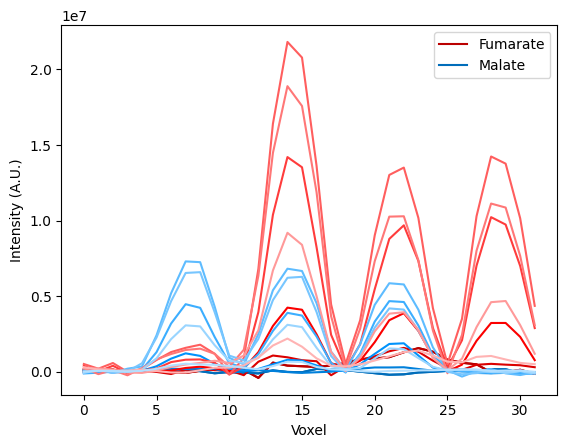

In [54]:
clsPyr = ["#ba0000ff", '#db0000ff', '#fb0000ff', '#ff3c3cff', '#ff5e5eff', '#ff7777ff', '#ff9999ff', '#ffb3b3ff']
clsLac = ["#006dbaff", '#0080dbff', '#0092fbff', '#3caeffff', '#5ebcffff', '#77c6ffff', '#99d5ffff', '#b3dfffff']

plt.figure()
plt.plot(pyrINT3['0'][0,::], c=clsPyr[0], label="Fumarate")
plt.plot(lacINT3['0'][0,::], c=clsLac[0], label="Malate")
for i in range(0,np.shape(pyrINT3['0'])[0]):
    plt.plot(pyrINT3['0'][i,::], c=clsPyr[i])
    plt.plot(lacINT3['0'][i,::], c=clsLac[i])
    
plt.xlabel("Voxel")
plt.ylabel("Intensity (A.U.)")
plt.legend()
plt.show()

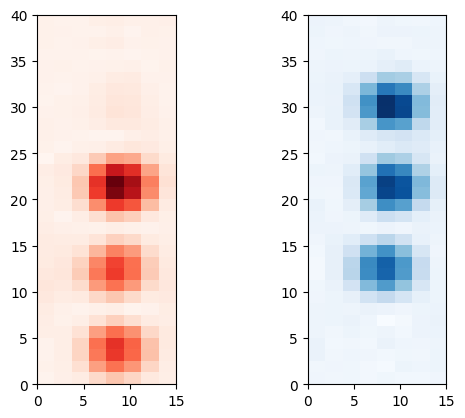

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(np.transpose(pyrINT3[str(0)]), cmap = 'Reds',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]])
ax2.imshow(np.transpose(lacINT3[str(0)]), cmap = 'Blues',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]])

plt.savefig('Processed/'+savNM3a+'WaterFatVoxels_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM3a+'WaterFatVoxels_Exp'+str(exp)+'.png')

plt.show()

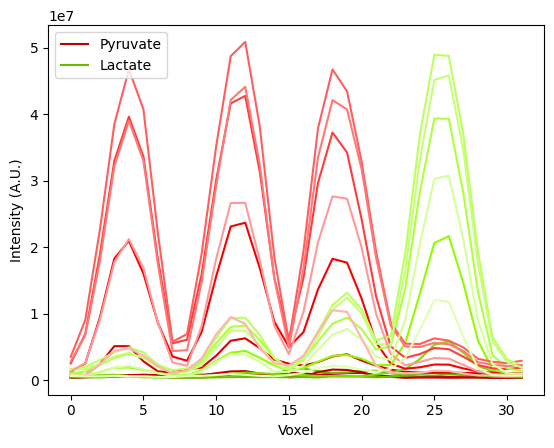

In [56]:
clsPyr = ["#ba0000ff", '#db0000ff', '#fb0000ff', '#ff3c3cff', '#ff5e5eff', '#ff7777ff', '#ff9999ff', '#ffb3b3ff']
clsLac = ["#6dba00ff", '#80db00ff', '#92fb00ff', '#aeff3cff', '#bcff5eff', '#c6ff77ff', '#d5ff99ff', '#dfffb3ff']

plt.figure()
plt.plot(pyrINT3['1'][0,::], c=clsPyr[0], label="Pyruvate")
plt.plot(lacINT3['1'][0,::], c=clsLac[0], label="Lactate")
for i in range(np.shape(pyrINT3['1'][4:12,::])[0]):
    plt.plot(pyrINT3['1'][4:12,::][i,::], c=clsPyr[i])
    plt.plot(lacINT3['1'][4:12,::][i,::], c=clsLac[i])
    
plt.xlabel("Voxel")
plt.ylabel("Intensity (A.U.)")
plt.legend()
plt.show()

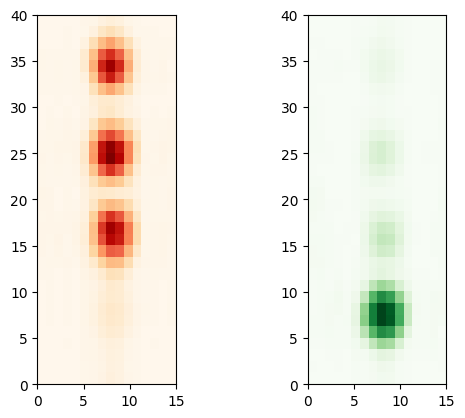

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(np.transpose(pyrINT3[str(1)]), cmap = 'OrRd',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]])
ax2.imshow(np.transpose(lacINT3[str(1)]), cmap = 'Greens',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]])

plt.savefig('Processed/'+savNM3b+'WaterFatVoxels_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM3b+'WaterFatVoxels_Exp'+str(exp)+'.png')

plt.show()

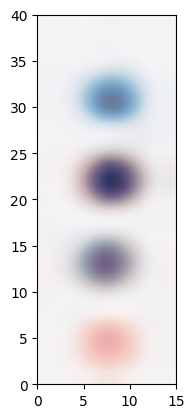

In [239]:
exp = 0

f = RectBivariateSpline(range(np.shape(pyrINT3[str(exp)])[0]), range(np.shape(pyrINT3[str(exp)])[1]), pyrINT3[str(exp)])
x2 = np.linspace(0, np.shape(pyrINT3[str(exp)])[0], 2000)
y2 = np.linspace(0, np.shape(pyrINT3[str(exp)])[1], 2000)
Z2 = f(x2, y2).T

fb = RectBivariateSpline(range(np.shape(lacINT3[str(exp)])[0]), range(np.shape(lacINT3[str(exp)])[1]), lacINT3[str(exp)])
x2b = np.linspace(0, np.shape(lacINT3[str(exp)])[0], 2000)
y2b = np.linspace(0, np.shape(lacINT3[str(exp)])[1], 2000)
Z2b = fb(x2b, y2b).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'Reds',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]], alpha=0.9)
ax1.imshow(Z2b, cmap = 'Blues',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]], alpha=0.6)

plt.savefig('Processed/'+savNM3a+'WaterFatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM3a+'WaterFatSmooth_Exp'+str(exp)+'.png')

plt.show()


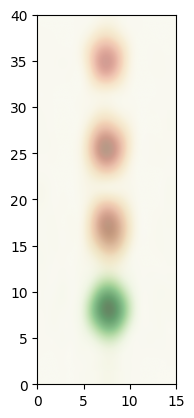

In [238]:
exp = 1

f = RectBivariateSpline(range(np.shape(pyrINT3[str(exp)])[0]), range(np.shape(pyrINT3[str(exp)])[1]), pyrINT3[str(exp)])
x2 = np.linspace(0, np.shape(pyrINT3[str(exp)])[0], 2000)
y2 = np.linspace(0, np.shape(pyrINT3[str(exp)])[1], 2000)
Z2 = f(x2, y2).T

fb = RectBivariateSpline(range(np.shape(lacINT3[str(exp)])[0]), range(np.shape(lacINT3[str(exp)])[1]), lacINT3[str(exp)])
x2b = np.linspace(0, np.shape(lacINT3[str(exp)])[0], 2000)
y2b = np.linspace(0, np.shape(lacINT3[str(exp)])[1], 2000)
Z2b = fb(x2b, y2b).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'OrRd',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]], alpha=0.9)
ax1.imshow(Z2b, cmap = 'Greens',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]], alpha=0.6)

plt.savefig('Processed/'+savNM3b+'WaterFatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM3b+'WaterFatSmooth_Exp'+str(exp)+'.png')

plt.show()


# Chip EPSI

### Load Data and Visualise

In [58]:
mainPth = r'C:\IBECPostDocDrive\2025_11_10_CheShImP_MRMJournal\Data' # Directory where all the result folders are

exps4 = [r'\EPSI\20240514_201021_DGC_EPSIProcessingTests_HCoil_Chip8Try2_1_3\5_EPSI',
         r'\EPSI\20250718_190035_DGC_MultiWell4WellChips_EPSI_HepG2_HepG2_Normal_Triplicate_Pippete_Rep1_1_1\5_EPSI', 
        ] # List of experiments (and CSI folder) to analyse

In [59]:
ppms4 = {}
CSIs4 = {}
for i in range(len(exps4)):
    ppms4[str(i)] = sp.io.loadmat(mainPth+exps4[i]+r'\tmp_img\ppms.mat')['ppms'][0]   
    try:
        CSIs4[str(i)] = sp.io.loadmat(mainPth+exps4[i]+r'\tmp_img\AllData.mat')['FDat'][::,::,::,0,0,0,0]
    except:
        CSIs4[str(i)] = sp.io.loadmat(mainPth+exps4[i]+r'\tmp_img\AllData.mat')['FDat'][::,::,::]

### Inspec CSI Processed Data

In [9]:
inspecCSI(ppms4, CSIs4)    

interactive(children=(Dropdown(description='Exp.:', options=(1, 2), value=1), IntSlider(value=0, description='…

In [10]:
genCSI(CSIs4, '4_RatiosMap_ChipEPSI')

interactive(children=(Dropdown(description='Exp.:', options=(1, 2), value=1), FloatRangeSlider(value=(5.0, 5.0…

In [13]:
np.shape(CSIs4['0'])

(256, 16, 16)

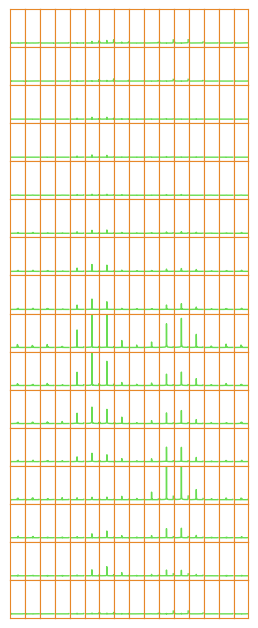

In [15]:
# CSIs3a = {}
# CSIs3a['0'] = np.transpose(CSIs3['0'], axes=(0, 2, 1))

plotCSIDat2(CSIs4, savNM="4_RatiosMap_ChipEPSIWater", exp = 1, scF = [2.98113, 7.61132], lw1 = 1, mnn = -0.1, mxx = 0.82, xzm = [0,256], sav = True)

In [17]:
np.shape(CSIs4['1'])

(248, 32, 32)

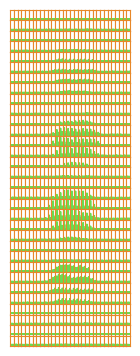

In [60]:
CSIs4b = {}
CSIs4b['0'] = CSIs4['1'] #np.transpose(CSIs3['1'], axes=(0, 2, 1))
plotCSIDat2(CSIs4b, savNM="4_RatiosMap_ChipEPSIPyr", exp = 1, scF = [1.5, 4.2], lw1 = 1, mnn = -0.1, mxx = 0.82, xzm = [0,248], sav = True)

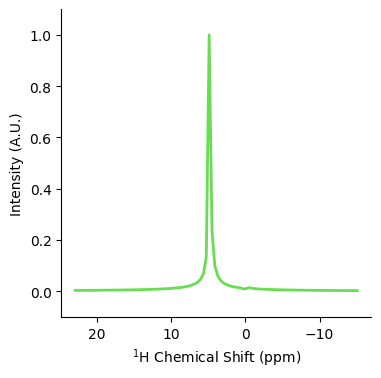

In [61]:
exp = 1
j,i = 5,8

savNM4a = "4_RatiosMap_ChipEPSIWater"


sizDt = np.shape(CSIs4[str(exp-1)])
mxdt = np.max(CSIs4[str(exp-1)][::,j,i])
mndt = np.min(CSIs4[str(exp-1)][::,j,i])

fig2, ax2 = plt.subplots(figsize=(4,4))
            
ax2.spines[['right', 'top']].set_visible(False)

ax2.set_ylim(-0.1,1.1)
ax2.plot(ppms4[str(exp-1)][80:180], (CSIs4[str(exp-1)][80:180,j,i] - mndt) / (mxdt - mndt),  color="#69dd52ff", linewidth = 2)
ax2.set_ylabel("Intensity (A.U.)")
ax2.set_xlabel("$^{1}$H Chemical Shift (ppm)")
ax2.set_xlim(ax2.get_xlim()[::-1])

plt.savefig('Processed/'+savNM4a+'ExampleSpectra_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM4a+'ExampleSpectra_Exp'+str(exp)+'.png')

plt.show()

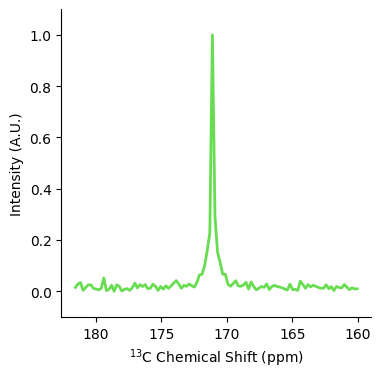

In [62]:
exp = 2
j,i = 17,13

savNM4b = "4_RatiosMap_ChipEPSIPyr"

# ppmsfx = np.linspace(261.8202885852775-60, 138.1797114147225, 512)
# ppms3[str(exp-1)] = ppmsfx+10

sizDt = np.shape(CSIs4[str(exp-1)])
mxdt = np.max(CSIs4[str(exp-1)][::,j,i])
mndt = np.min(CSIs4[str(exp-1)][::,j,i])

fig2, ax2 = plt.subplots(figsize=(4,4))
            
ax2.spines[['right', 'top']].set_visible(False)

ax2.set_ylim(-0.1,1.1)
ax2.plot(ppms4[str(exp-1)][70:180], (CSIs4[str(exp-1)][70:180,j,i] - mndt) / (mxdt - mndt),  color="#69dd52ff", linewidth = 2)
ax2.set_ylabel("Intensity (A.U.)")
ax2.set_xlabel("$^{13}$C Chemical Shift (ppm)")
ax2.set_xlim(ax2.get_xlim()[::-1])

plt.savefig('Processed/'+savNM4b+'ExampleSpectra_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM4b+'ExampleSpectra_Exp'+str(exp)+'.png')

plt.show()

### Select Integration Regions for Water and Fat

In [38]:
dispInts(ppms4, CSIs4, intNM = 'IntegrParsChipEPSI')

interactive(children=(Dropdown(description='Exp.:', options=(1, 2), value=1), IntSlider(value=0, description='…

In [63]:
with open('Processed/'+'IntegrParsChipEPSI'+'.p', 'rb') as fp:
    intPars4 = pickle.load(fp)
intPars4

{'0': [(-9.328969187238073, 0.1181009127619177),
  (-46.97546448723804, -24.15221688723807)],
 '1': [(-175.57656078723807, -166.86673048723807),
  (-191.29016978723806, -180.63138008723806)]}

### Generate and visualise the ratios map for each experiment

In [64]:
# Generate normalised matrix by maximum of each row to account for lower signals due to magnetic inhomogeneities
CSIs_FC_NRMRW4 = {}

for ex in range(len(CSIs4)):
    shp = np.shape(CSIs4[str(ex)])

    CSIs_FC_NRMRW4[str(ex)] = np.zeros(shp)
    
    for ii in range(shp[2]):
        mxrw4 = np.max([np.max(CSIs4[str(ex)][::,jj,ii]) for jj in range(shp[1])])
        CSIs_FC_NRMRW4[str(ex)][::,::,ii] = CSIs4[str(ex)][::,::,ii] #/ mxrw3

In [ ]:
# Fumarate - Reds, Blues
# LDH - OrRd, Greens

In [44]:
pltRatsMaps(ppms4, CSIs_FC_NRMRW4, intNM = 'IntegrParsChipEPSI', savNM = '4_RatiosMap_ChipEPSI', logg=True)

interactive(children=(FloatSlider(value=0.5, description='Zoom', layout=Layout(width='1400px'), max=2.0, min=0…

In [65]:
pyrINT4 = {}
lacINT4 = {}

for ex in range(len(CSIs_FC_NRMRW4)):
    pyrIntR = np.logical_and(ppms4[str(ex)] >= np.abs(intPars4[str(ex)][0])[1],  ppms4[str(ex)] <= np.abs(intPars4[str(ex)][0])[0])
    lacIntR = np.logical_and(ppms4[str(ex)] >= np.abs(intPars4[str(ex)][1])[1],  ppms4[str(ex)] <= np.abs(intPars4[str(ex)][1])[0])
    
    sizDt = np.shape(CSIs_FC_NRMRW4[str(ex)])
    pyrMat = np.zeros([sizDt[1], sizDt[2]])
    lacMat = np.zeros([sizDt[1], sizDt[2]])

    for i in range(sizDt[2]):
        for j in range(sizDt[1]):
            pyrMat[j,i] = auc(ppms4[str(ex)][pyrIntR], CSIs_FC_NRMRW4[str(ex)][pyrIntR, j,i])
            lacMat[j,i] = auc(ppms4[str(ex)][lacIntR], CSIs_FC_NRMRW4[str(ex)][lacIntR, j,i])
            
    pyrINT4[str(ex)] = pyrMat
    lacINT4[str(ex)] = lacMat

In [66]:
dms4 = []
with open(mainPth+'/'+exps4[0]+'/visu_pars', 'r+') as f:
    for line in f:
        if 'VisuCoreExtent' in line.strip():
            dms4 = np.fromstring(next(f,''), dtype=float, sep=' ' )
            break

array([33.4468, 40.9539])

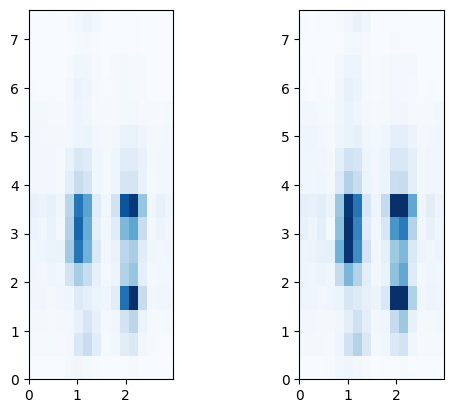

In [76]:
# Addition of Saturation

pyrINT4Sat = {}

sat = 0.75

pyrINT4Sat['0'] = np.zeros(np.shape(pyrINT4[str(0)]))

for i in range(np.shape(pyrINT4[str(0)])[0]):
    for j in range(np.shape(pyrINT4[str(0)])[1]):
        mm = np.max(pyrINT4[str(0)])
        satTh = mm*sat
        
        if pyrINT4[str(0)][i,j] >= satTh:
            pyrINT4Sat['0'][i,j] = satTh
        else:
            pyrINT4Sat['0'][i,j] = pyrINT4[str(0)][i,j]
        
        
        
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(np.transpose(pyrINT4[str(0)]), cmap = 'Blues',  extent = [0, 2.98113, 0, 7.61132])
ax2.imshow(np.transpose(pyrINT4Sat[str(0)]), cmap = 'Blues',  extent = [0, 2.98113, 0, 7.61132])

plt.savefig('Processed/'+savNM4a+'WaterVoxels_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM4a+'WaterVoxels_Exp'+str(exp)+'.png')

plt.show()

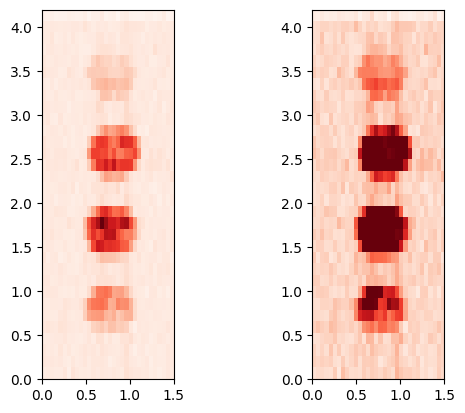

In [77]:
# Addition of Saturation

# pyrINT4Sat = {}

sat = 0.5

pyrINT4Sat['1'] = np.zeros(np.shape(pyrINT4[str(1)]))

for i in range(np.shape(pyrINT4[str(1)])[0]):
    for j in range(np.shape(pyrINT4[str(1)])[1]):
        mm = np.max(pyrINT4[str(1)])
        satTh = mm*sat
        
        if pyrINT4[str(1)][i,j] >= satTh:
            pyrINT4Sat['1'][i,j] = satTh
        else:
            pyrINT4Sat['1'][i,j] = pyrINT4[str(1)][i,j]
        
        
        
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(np.transpose(pyrINT4[str(1)]), cmap = 'Reds',  extent = [0, 1.5, 0, 4.2])
ax2.imshow(np.transpose(pyrINT4Sat[str(1)]), cmap = 'Reds',  extent = [0, 1.5, 0, 4.2])

plt.savefig('Processed/'+savNM4b+'WaterVoxels_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM4b+'WaterVoxels_Exp'+str(exp)+'.png')

plt.show()

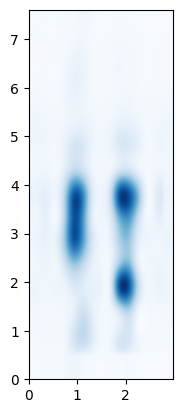

In [78]:
exp = 0

# f = RectBivariateSpline(range(np.shape(pyrINT4[str(exp)])[0]), range(np.shape(pyrINT4[str(exp)])[1]), pyrINT4[str(exp)])
# x2 = np.linspace(0, np.shape(pyrINT4[str(exp)])[0], 2000)
# y2 = np.linspace(0, np.shape(pyrINT4[str(exp)])[1], 2000)
# Z2 = f(x2, y2).T

fb = RectBivariateSpline(range(np.shape(pyrINT4Sat[str(exp)])[0]), range(np.shape(pyrINT4Sat[str(exp)])[1]), pyrINT4Sat[str(exp)])
x2b = np.linspace(0, np.shape(pyrINT4Sat[str(exp)])[0], 2000)
y2b = np.linspace(0, np.shape(pyrINT4Sat[str(exp)])[1], 2000)
Z2b = fb(x2b, y2b).T


fig, ax1 = plt.subplots()

# ax1.imshow(Z2, cmap = 'Reds',  extent = [0, dms4[-2::][0], 0, dms4[-2::][1]], alpha=0.9)
ax1.imshow(Z2b, cmap = 'Blues',  extent = [0, 2.98113, 0, 7.61132], alpha=1)

plt.savefig('Processed/'+savNM4a+'WaterFatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM4a+'WaterFatSmooth_Exp'+str(exp)+'.png')

plt.show()


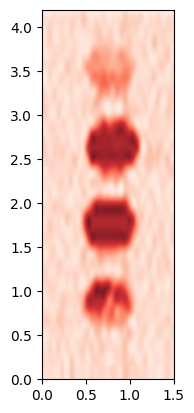

In [79]:
exp = 1

f = RectBivariateSpline(range(np.shape(pyrINT4Sat[str(exp)])[0]), range(np.shape(pyrINT4Sat[str(exp)])[1]), pyrINT4Sat[str(exp)])
x2 = np.linspace(0, np.shape(pyrINT4Sat[str(exp)])[0], 2000)
y2 = np.linspace(0, np.shape(pyrINT4Sat[str(exp)])[1], 2000)
Z2 = f(x2, y2).T


fig, ax1 = plt.subplots()

ax1.imshow(Z2, cmap = 'Reds',  extent = [0, 1.5, 0, 4.2], alpha=0.9)
# ax1.imshow(Z2b, cmap = 'Greens',  extent = [0, dms3[-2::][0], 0, dms3[-2::][1]], alpha=0.6)

plt.savefig('Processed/'+savNM4b+'WaterFatSmooth_Exp'+str(exp)+'.svg')
plt.savefig('Processed/'+savNM4b+'WaterFatSmooth_Exp'+str(exp)+'.png')

plt.show()
